In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import datetime

def accuracy(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true), ', set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def precision(y_true, y_pred, normalize=True, sample_weight=None):
    pre_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_prec = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_prec = 1
            pre_list.append(tmp_prec)
        elif len(set_pred) > 0:
            tmp_prec = len(set_true.intersection(set_pred))/\
                    float(len(set_pred))
            pre_list.append(tmp_prec)
        else:
            None
    return np.mean(pre_list)

def recall(y_true, y_pred, normalize=True, sample_weight=None):
    rec_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_rec = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_rec = 1
        else:
            tmp_rec = len(set_true.intersection(set_pred))/\
                    float(len(set_true))
        rec_list.append(tmp_rec)
    return np.mean(rec_list)

def f_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = (2*len(set_true.intersection(set_pred)))/\
                    float( len(set_true) + len(set_pred))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
from csv import writer
import pandas as pd

def test_segment(filename, low, up):
    myFile = open(filename, 'w', newline = '')
    with myFile:
        csv_writer = writer(myFile)
        for j, row in enumerate(seqData):
            segment = [ ]
            if(len(row) > low and len(row) < up):
                segment.append(row)
                for item in label[j]:
                    segment.append(item)
                csv_writer.writerow(segment)
    myFile.close()

dataframe = pd.read_csv("/content/gdrive/MyDrive/B_tech_minor_project/dataset/MF/testData1.csv", header=None) #Change the path
dataset = dataframe.values
seqData = dataset[:,0]
label = dataset[:,1:len(dataset[0])]
print('Original Dataset Size : %s' %len(dataset))
test_segment('testData200.csv', 0, 201)
test_segment('testData500.csv', 200, 501)
test_segment('testData1000.csv', 500, 1001)
test_segment('testData16000.csv', 1000, 16000)

Original Dataset Size : 3132


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import math

def segment(dataset, label, seg_size, overlap):
    print("Non-overlapping Region: %s" %overlap)
    print("Segment Size: %s" %seg_size)
  
    seq_data, label_data = [], []
    for j, row in enumerate(dataset):
        if(len(row) < 2001):
            pos = math.ceil(len(row)/overlap)
            if(pos < math.ceil(seg_size/overlap)):
                pos = math.ceil(seg_size/overlap)
            for itr in range(pos - math.ceil(seg_size/overlap) + 1):
                init = itr * overlap
                if(len(row[init : init + seg_size]) > 50):
                    seq_data.append(row[init : init + seg_size])
                    label_data.append(label[j])
    return seq_data, label_data

dataframe = pd.read_csv('/content/gdrive/MyDrive/B_tech_minor_project/dataset/MF/trainData.csv', header=None)
dataset = dataframe.values
print('Original Dataset Size : %s' %len(dataset))
X = dataset[:,0]
Y = dataset[:,1:len(dataset[0])]
del dataframe, dataset
print(X.shape, Y.shape)

# Preparing For Training
segmentSize = 200
nonOL = segmentSize - 50
SEG = str(segmentSize)

X, Y = segment(X, Y, segmentSize, nonOL)
nb_of_cls = len(Y[0])

#Split the dataset
x_tr, x_val, y_tr, y_val = train_test_split(X, Y, test_size = 0.1, random_state = 42)
del X, Y

y_train = np.array(y_tr, dtype=float)
y_validate = np.array(y_val, dtype=float)
print(len(x_tr), len(x_val))
print(y_train.shape, y_validate.shape)

del y_tr, y_val

Original Dataset Size : 32280
(32280,) (32280, 135)
Non-overlapping Region: 150
Segment Size: 200
84011 9335
(84011, 135) (9335, 135)


In [ ]:
import math
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
np.random.seed(7)

def dictionary(chunk_size):
    dataframe = pd.read_csv('/content/gdrive/MyDrive/B_tech_minor_project/dataset/MF/trainData.csv', header=None)
    dataset = dataframe.values
    del dataframe

    seq_dataset = dataset[:,0]
    print('Creating Dictionary:')
    dict = {}
    j = 0
    for row in seq_dataset:
        for i in range(len(row) - chunk_size + 1):
            key = row[i:i + chunk_size]
            if key not in dict:
                dict[key] = j
                j = j + 1
    del dataset, seq_dataset
    return(dict)

def nGram(dataset, chunk_size, dictI):
    dict1 = list()
    for j, row in enumerate(dataset):
        string = row
        dict2 = list()
        for i in range(len(string) - chunk_size + 1):
            try:
                dict2.append(dictI[string[i:i + chunk_size]])
            except:
                None
        dict1.append(dict2)   
    return(dict1)

# CREATING DICTIONARY
chunkSize = 4
dict_Prop = dictionary(chunkSize)
max_seq_len = segmentSize - chunkSize + 1

Creating Dictionary:


In [ ]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
np.random.seed(7)

'''
class Attention_layer(tf.keras.layers.Layer):
    def __init__(self,inputs):
        super(Attention_layer,self).__init__()
        self.W=self.add_weight(name='attention_weight', shape=(inputs,1),initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(inputs,1),initializer='zeros', trainable=True) 
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

    def get_conig(self):
      config = super().get_cofig().copy()
      config.update({'inputs':inputs,})
      return config

'''

class Bi_CNN(tf.keras.layers.Layer):
    def __init__(self, no_of_filters, filter_size,dilation_rate):
        super(Bi_CNN,self).__init__()
        self.forward_cnn = tf.keras.layers.Conv1D(filters = no_of_filters, kernel_size=filter_size, dilation_rate=dilation_rate,
                                                  strides=1, padding='causal',activation='linear',use_bias=True)
        # self.backward_cnn = tf.keras.layers.Conv1D(filters = no_of_filters, kernel_size=filter_size, dilation_rate=dilation_rate,
        #                                            strides=1, padding='causal',activation='linear',use_bias=True)
        
        self.forward_gated_cnn = tf.keras.layers.Conv1D(filters = no_of_filters, kernel_size=filter_size, dilation_rate=dilation_rate,
                                                    strides=1, padding='causal',activation='sigmoid',use_bias=True)
        # self.backward_gated_cnn = tf.keras.layers.Conv1D(filters = no_of_filters, kernel_size=filter_size, dilation_rate=dilation_rate,
        #                                             strides=1, padding='causal',activation='sigmoid',use_bias=True)
        
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.add = tf.keras.layers.Add()

    def call(self, inputs, mode='Concat'):
        f_cnn = self.forward_cnn(inputs)                  # Forward Pass
        f_gated_cnn = self.forward_gated_cnn(inputs)
        f_int = tf.multiply(f_cnn, f_gated_cnn)

        # r_input = tf.reverse(inputs, [-2])                # Backward Pass
        # b_cnn = self.backward_cnn(r_input)  
        # b_cnn = tf.reverse(b_cnn, [-2])

        # b_gated_cnn = self.backward_gated_cnn(r_input)
        # b_gated_cnn = tf.reverse(b_gated_cnn, [-2])


        # b_int = tf.multiply(b_cnn, b_gated_cnn)


        # if mode is 'Concat':
        #     output = self.concat([f_int, b_int])

        # elif mode == 'Add':
        #     output = self.add([f_int, b_int])

        # else:
        #     output = f_int, b_int
        output = f_int
        return output

    def get_config(self):
        config = super().get_config().copy()
        config.update({'no_of_filters': self.no_of_filters, 'filter_size': self.filter_size, 'dilation_rate': self.dilation_rate,})
        return config


def DC_CNN_Block(nb_filter, filter_length, dilation, l2_layer_reg):
    def f(input_):
        residual = input_
        layer_out = Bi_CNN(no_of_filters = nb_filter, filter_size = filter_length, dilation_rate=dilation)(input_)
        '''
        layer_out = layers.Conv1D(filters=nb_filter, kernel_size=filter_length, dilation_rate=dilation, 
                                  activation='linear', padding='same', use_bias=True) (input_)
                                  '''
        layer_out = layers.BatchNormalization(epsilon=1.1e-5)(layer_out)
        layer_out = layers.LeakyReLU(alpha = 0.2)(layer_out)
        #network_out = layers.Add()([residual, layer_out])
        return layer_out
    return f

embed_dim = 32
ff_dim = 300

def DC_CNN_Model(top_words, seq_len, o_dim):
    #embed_dim = 32
    f_num = 128
    f_size = [4,4,4,4,4]
    #ff_dim = 200

    _input = layers.Input(shape=(seq_len,))
    emd = layers.Embedding(top_words, embed_dim, input_length = seq_len)(_input)
    drop1 = layers.Dropout(0.3)(emd)

    l1 = DC_CNN_Block(f_num, f_size[0], 1, 0.001)(drop1) 
    l2 = DC_CNN_Block(f_num, f_size[1], 3, 0.001)(drop1)
    l3 = DC_CNN_Block(f_num, f_size[2], 5, 0.001)(drop1)
    l4 = DC_CNN_Block(f_num, f_size[3], 7, 0.001)(drop1)
    l5 = DC_CNN_Block(f_num, f_size[4], 9, 0.001)(drop1)

    c_x = layers.Concatenate()([l1, l2, l3, l4, l5])

    #x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='linear', padding='valid')(c_x)
    #x = layers.BatchNormalization(epsilon=1.1e-5)(x)
    #x = layers.LeakyReLU(alpha = 0.2)(c_x)
    #x = layers.Lambda(lambda xin: K.sum(xin, axis=1))(x)
    x = layers.GlobalAveragePooling1D()(c_x)
    x = layers.Dropout(0.4)(x)
    _output = layers.Dense(o_dim, kernel_initializer='normal', activation='sigmoid', name='CLASSIFIER')(x)

    model = keras.Model(inputs=_input, outputs=_output)
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                  # loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
                  metrics = tf.keras.metrics.BinaryAccuracy(threshold=0.5))
    return model

#CREATING N-GRAM
x_train = nGram(x_tr, chunkSize, dict_Prop)
x_validate = nGram(x_val, chunkSize, dict_Prop)

# truncate and pad input sequences
x_train = sequence.pad_sequences(x_train, maxlen=max_seq_len)
x_validate = sequence.pad_sequences(x_validate, maxlen=max_seq_len)

# Create & Compile the model
model = DC_CNN_Model(len(dict_Prop), max_seq_len, nb_of_cls)
print(model.summary())
early_stopping_monitor1 = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
history = model.fit(x_train, y_train,
          validation_data = (x_validate, y_validate),
          epochs = 500,
          batch_size = 150,
          callbacks=[early_stopping_monitor1],
          verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 197)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 197, 32)      5123872     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 197, 32)      0           ['embedding[0][0]']              
                                                                                                  
 bi_cnn (Bi_CNN)                (None, 197, 128)     33024       ['dropout[0][0]']                
                                                                                              

In [ ]:
#pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
from keras.models import load_model

def cls_predict(pred, normalize=True, sample_weight=None):
    s_mean = np.mean(pred, axis=0)
    m = max(s_mean)
    s_mean = (s_mean/m)
    return(list(s_mean))

def final_model(filename):
    print('Extracting features based on GRU model...... ')
    dataframe2 = pd.read_csv(filename, header=None)
    dataset2 = dataframe2.values
    overlap = 50
    X_test = dataset2[:,0]
    Y_test = dataset2[:,1:len(dataset2[0])]
    c_p = []
    for tag, row in enumerate(X_test):
        pos = math.ceil(len(row) / overlap)
        if(pos < math.ceil(segmentSize/ overlap)):
            pos = math.ceil(segmentSize/ overlap)
        segment = [ ]
        for itr in range(pos - math.ceil(segmentSize/overlap) + 1):
            init = itr * overlap
            segment.append(row[init : init + segmentSize])
        seg_nGram = nGram(segment, chunkSize, dict_Prop)
        test_seg = sequence.pad_sequences(seg_nGram, maxlen=max_seq_len)
        preds = model.predict(test_seg)
        c_p.append(cls_predict(preds))
    c_p = np.array(c_p)
    return c_p, Y_test

def create_nn_model(dim):
    n_model = keras.Sequential(
        [layers.Dense(dim, input_dim = dim, kernel_initializer='normal', activation='relu'),
        layers.Dense(dim, kernel_initializer='normal', activation='sigmoid'),]
        )
    n_model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
                    metrics = tf.keras.metrics.BinaryAccuracy(threshold=0.5))
    return n_model

# Creates a HDF5 file 'my_model.h5'

#model_path = '/content/gdrive/MyDrive/B_tech_minor_project/dataset/BP/'+str(embed_dim)+'_model_'+str(ff_dim)+'_'+str(nonOL)+'_'+str(6)+'_'+ SEG +'.h5'
#model.save(model_path)
#del model  
#model = load_model(model_path)

# Training
X_train_new, Y_train_new = final_model('/content/gdrive/MyDrive/B_tech_minor_project/dataset/MF/trainData.csv')

# Training model 2
model1 = create_nn_model(Y_train_new[0].shape[0])
print(model1.summary())
early_stopping_monitor = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
model1.fit(X_train_new, Y_train_new.astype(None),
           callbacks = [early_stopping_monitor],
           validation_split = 0.1,
           epochs = 1000,
           batch_size = 150,
           verbose = True)

Extracting features based on GRU model...... 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 135)               18360     
                                                                 
 dense_1 (Dense)             (None, 135)               18360     
                                                                 
Total params: 36,720
Trainable params: 36,720
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
194/194 [==============================] - 1s 4ms/step - loss: 0.3496 - binary_accuracy: 0.9674 - val_loss: 0.0929 - val_binary_accuracy: 0.9894
Epoch 2/1000
194/194 [==============================] - 1s 3ms/step - loss: 0.0763 - binary_accuracy: 0.9895 - val_loss: 0.0719 - val_binary_accuracy: 0.9894
Epoch 3/1000
194/194 [==============================] - 1s 3ms/step - loss: 0.068

Extracting features based on GRU model...... 
(3132, 135) (3132, 135)
THRESHOLD IS =====>  0.01
Recall: 65.51962334529384      Precision: 53.95797742068511      F1-score1: 59.17939989440817       F1-score2: 55.07196637755276
THRESHOLD IS =====>  0.02
Recall: 63.60813365363174      Precision: 55.982893409287605      F1-score1: 59.55241716289444       F1-score2: 56.327988429569906
THRESHOLD IS =====>  0.03
Recall: 62.710145147884624      Precision: 56.70700523551994      F1-score1: 59.55768527056565       F1-score2: 56.70895373219081
THRESHOLD IS =====>  0.04
Recall: 61.98820673437532      Precision: 57.17337508004062      F1-score1: 59.48351708998184       F1-score2: 56.85462640576684
THRESHOLD IS =====>  0.05
Recall: 61.616468000567615      Precision: 57.52410198890083      F1-score1: 59.500000541776984       F1-score2: 57.03017004592621
THRESHOLD IS =====>  0.06
Recall: 61.24227322982112      Precision: 57.74059043621483      F1-score1: 59.43990431884815       F1-score2: 57.0733110150

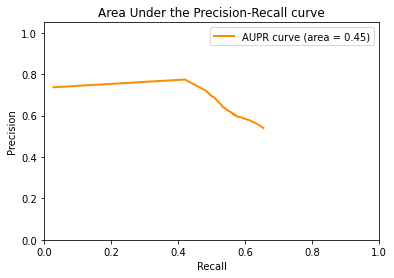

In [ ]:
from matplotlib import pyplot as plt

# Testing
def final_model_testing(filename):
    print('Extracting features based on GRU model...... ')
    dataframe2 = pd.read_csv(filename, header=None)
    dataset2 = dataframe2.values
    overlap = 50
    X_test = dataset2[:,0]
    Y_test = dataset2[:,1:len(dataset2[0])]
    c_p = []
    for tag, row in enumerate(X_test):
        pos = math.ceil(len(row) / overlap)
        if(pos < math.ceil(segmentSize/ overlap)):
            pos = math.ceil(segmentSize/ overlap)
        segment = [ ]
        for itr in range(pos - math.ceil(segmentSize/overlap) + 1):
            init = itr * overlap
            segment.append(row[init : init + segmentSize])
        seg_nGram = nGram(segment, chunkSize, dict_Prop)
        test_seg = sequence.pad_sequences(seg_nGram, maxlen=max_seq_len)
        preds = model.predict(test_seg)
        c_p.append(cls_predict(preds))
    c_p = np.array(c_p)
    return c_p, Y_test

def test_fun(file):
    X_test_new, Y_test_new = final_model_testing(file)
    print(X_test_new.shape, Y_test_new.shape)
    Y_test_new = np.array(Y_test_new).astype(None)

    fmax, tmax = 0.0, 0.0
    precisions, recalls = [], []
    for t in range(1, 101, 1):
        test_preds = model1.predict(X_test_new)

        threshold = t / 100.0
        if threshold == 1.0:
          threshold = 0.999
        print("THRESHOLD IS =====> ", threshold)
        test_preds[test_preds>=threshold] = int(1)
        test_preds[test_preds<threshold] = int(0)

        rec = recall(Y_test_new, test_preds)
        pre = precision(Y_test_new, test_preds)
        if math.isnan(pre):
          pre = 0.0
        recalls.append(rec)
        precisions.append(pre)

        f1 = f_score(Y_test_new, test_preds)*100
        f = 2 * pre * rec / (pre + rec)
        if math.isnan(f):
          f = 0.0
        print('Recall: {0}'.format(rec*100), '     Precision: {0}'.format(pre*100),
              '     F1-score1: {0}'.format(f*100), '      F1-score2: {0}'.format(f1))

        if fmax < f:
            fmax = f
            tmax = threshold
    
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    sorted_index = np.argsort(recalls)
    recalls = recalls[sorted_index]
    precisions = precisions[sorted_index]
    aupr = np.trapz(precisions, recalls)
    print(f'AUPR: {aupr:0.3f}')

    plt.figure()
    plt.plot(recalls, precisions, color='darkorange', lw=2, label=f'AUPR curve (area = {aupr:0.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Area Under the Precision-Recall curve')
    plt.legend(loc="upper right")
    plt.savefig(f'aupr.pdf')

    return tmax

th_set = test_fun("/content/gdrive/MyDrive/B_tech_minor_project/dataset/MF/testData1.csv")

In [ ]:
def test_fun(file):
    X_test_new, Y_test_new = final_model_testing(file)
    print(X_test_new.shape, Y_test_new.shape)
    test_preds = model1.predict(X_test_new)
    Y_test_new = np.array(Y_test_new).astype(None)
    test_preds[test_preds>=th_set] = int(1)
    test_preds[test_preds<th_set] = int(0)
    rec = recall(Y_test_new, test_preds)*100
    pre = precision(Y_test_new, test_preds)*100
    f = 2 * pre * rec / (pre + rec)
    f1 = f_score(Y_test_new, test_preds)*100
    print('   Recall: {0}'.format(rec),  '    Precision: {0}'.format(pre),  '    F1-score: {0}'.format(f), '    F1-score: {0}'.format(f1))

def test_fun_specific(file):
    X_test_new, Y_test_new = final_model(file)
    print(X_test_new.shape, Y_test_new.shape)
    test_preds = model1.predict(X_test_new)
    Y_test_new = np.array(Y_test_new).astype(None)
    test_preds[test_preds>=th_set] = int(1)
    test_preds[test_preds<th_set] = int(0)
    rec = recall(Y_test_new, test_preds)*100
    pre = precision(Y_test_new, test_preds)*100
    f = 2 * pre * rec / (pre + rec)
    f1 = f_score(Y_test_new, test_preds)*100
    print('   Recall: {0}'.format(rec),  '    Precision: {0}'.format(pre),  '    F1-score: {0}'.format(f), '    F1-score: {0}'.format(f1))

print("Best Threshold: ", th_set)
test_fun('/content/gdrive/MyDrive/B_tech_minor_project/dataset/MF/testData1.csv')
test_fun_specific("testData200.csv")
test_fun_specific("testData500.csv")
test_fun_specific("testData1000.csv")
test_fun_specific("testData16000.csv")

print('/n')
print("code Completion date is :", datetime.datetime.now())

Best Threshold:  0.03
Extracting features based on GRU model...... 
(3132, 135) (3132, 135)
   Recall: 62.710145147884624     Precision: 56.70700523551994     F1-score: 59.55768527056565     F1-score: 56.70895373219081
Extracting features based on GRU model...... 
(255, 135) (255, 135)
   Recall: 42.15686274509804     Precision: 37.10754604872252     F1-score: 39.47137812261979     F1-score: 37.45191409897292
Extracting features based on GRU model...... 
(1268, 135) (1268, 135)
   Recall: 58.869235391317396     Precision: 53.609494835487595     F1-score: 56.1163868816121     F1-score: 53.644628234741134
Extracting features based on GRU model...... 
(1160, 135) (1160, 135)
   Recall: 70.13297071702243     Precision: 64.56730856477306     F1-score: 67.2351562297343     F1-score: 64.43865290670564
Extracting features based on GRU model...... 
(449, 135) (449, 135)
   Recall: 66.05286880899352     Precision: 56.27839369418523     F1-score: 60.775132691307114     F1-score: 56.32957465602046